<a href="https://colab.research.google.com/github/ZurMaD/BWRL/blob/master/Entregable_Avance_BipedalWalker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


# Desarrollo y Comparación de Algoritmos de Aprendizaje por Refuerzo en Entorno Estocástico OpeanAI para Locomoción de un Bípedo en 2D.

---

@Autores: Díaz P., Lizano D., Villena A., Zegarra D.
@Última moficación: 15/05/19

## Resumen.-
El estudio tiene como fin crear un agente que supere obstáculos en el menor tiempo posible para una posterior implementación en robots rescatistas no tripulados. Este documento presenta una comparación entre algoritmos de aprendizaje por refuerzo que son capaces de superar el desafío Bipedal-Walker-Hardcore-v2 en el entorno de simulación OpenAI-Gym.

## Índice.-

<table align="left">
  <tr>
    <th>N°</th>
    <th>Título</th>
    <th>Descripción</th> 
  </tr>
  <tr>
    <td>1</td>
    <td>Adaptando el entorno</td> 
    <td></td> 
  </tr>
  <tr>
    <td>2</td>
    <td>Heuristica</td> 
    <td></td> 
  </tr>
  <tr>
    <td>3</td>
    <td>DDPG</td> 
    <td></td> 
  </tr>
  <tr>
    <td>4</td>
    <td></td> 
    <td></td> 
  </tr>
  <tr>
    <td>5</td>
    <td></td> 
    <td></td> 
  </tr>
  <tr>
    <td>6</td>
    <td></td> 
    <td></td> 
  </tr>
  <tr>
    <td>7</td>
    <td></td> 
    <td></td> 
  </tr>
  <tr>
    <td>8</td>
    <td></td> 
    <td></td> 
  </tr>
  <tr>
    <td>9</td>
    <td></td> 
    <td></td> 
  </tr>
  <tr>
    <td>10</td>
    <td></td> 
    <td></td> 
  </tr>
  <tr>
    <td>11</td>
    <td></td> 
    <td></td> 
  </tr>
  <tr>
    <td>12</td>
    <td></td> 
    <td></td> 
  </tr>
</table>



---

#  Análisis 

---

En análisis que se llevará a cabo es el de comparar algoritmos de aprendizaje por refuerzo

## 1 ) Generamos el entorno para guardar

Instalación de un display virtual

In [0]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [0]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [0]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [4]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 600))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x600x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x600x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [5]:
!pip install box2d-py
!pip install gym[Box_2D]

     |████████████████████████████████| 450kB 2.8MB/s 


In [0]:
import matplotlib
import os
import subprocess

# idea from
# https://stackoverflow.com/questions/34975972/how-can-i-make-a-video-from-array-of-images-in-matplotlib
i=1
def deleter(num_files=100):
  try:
    for i in range(num_files):
      os.system(str("rm /content/img%02d.png" % i))
      if i%50==0:
        print("deleter: Se ha borrado hasta la img",i)
    print("deleter: Se ha borrado hasta la img",i+1)
  except Exception as e:
    print("deleter",e)
    print("deleter: Algo salió mal en deleter")
    pass
  #print("video_generado.mp4 Borrado")
     
def generate_video(video,file_name):
  try:
    for i in range(len(video)):
      plt.imshow(video[i])
      plt.savefig("/content/img%02d.png" % i)
      if i%10==0:
        print("generate_video: Se ha generado hasta la img",i,"/",len(video))
    print("generate_video: Se ha generado hasta la img",i+1,"/",len(video))
  except Exception as e:
    print("generate_video",e)
    print("generate_video: Algo salió mal en generate_video")
    pass
  
  os.system("rm /content/"+file_name+".mp4")
  
  
  print("generate_video: Generando video...")
  subprocess.call([
      'ffmpeg', '-framerate', '8', '-i', '/content/img%02d.png', '-r', '30', '-pix_fmt', 'yuv420p'
      , file_name+'.mp4'
  ])
  

#deleter(50)

## Importamos las librerías a usar

In [0]:
import sys
import math

import numpy as np
import Box2D
from Box2D.b2 import (edgeShape, circleShape, fixtureDef, polygonShape, revoluteJointDef, contactListener)

import gym
from gym import spaces
from gym.utils import colorize, seeding, EzPickle

## Constantes globales

In [0]:
# This is simple 4-joints walker robot environment.
#
# There are two versions:
#
# - Normal, with slightly uneven terrain.
#
# - Hardcore with ladders, stumps, pitfalls.
#
# Reward is given for moving forward, total 300+ points up to the far end. If the robot falls,
# it gets -100. Applying motor torque costs a small amount of points, more optimal agent
# will get better score.
#
# Heuristic is provided for testing, it's also useful to get demonstrations to
# learn from. To run heuristic:
#
# python gym/envs/box2d/bipedal_walker.py
#
# State consists of hull angle speed, angular velocity, horizontal speed, vertical speed,
# position of joints and joints angular speed, legs contact with ground, and 10 lidar
# rangefinder measurements to help to deal with the hardcore version. There's no coordinates
# in the state vector. Lidar is less useful in normal version, but it works.
#
# To solve the game you need to get 300 points in 1600 time steps.
#
# To solve hardcore version you need 300 points in 2000 time steps.
#
# Created by Oleg Klimov. Licensed on the same terms as the rest of OpenAI Gym.

FPS    = 50
SCALE  = 30.0# escalamiento para dar formas 
# affects how fast-paced the game is, forces should be adjusted as well

MOTORS_TORQUE = 80
SPEED_HIP     = 4
SPEED_KNEE    = 6
LIDAR_RANGE   = 160/SCALE # rango de visión del laser

INITIAL_RANDOM = 5

HULL_POLY =[
    (-30,+9), (+6,+9), (+34,+1),
    (+34,-8), (-30,-8)
    ]#puntos para generar el body
LEG_DOWN = -8/SCALE
LEG_W, LEG_H = 8/SCALE, 34/SCALE

VIEWPORT_W = 600
VIEWPORT_H = 400

TERRAIN_STEP   = 14/SCALE 
TERRAIN_LENGTH = 200     # in steps
TERRAIN_HEIGHT = VIEWPORT_H/SCALE/4
TERRAIN_GRASS    = 10    # low long are grass spots, in steps
TERRAIN_STARTPAD = 20    # in steps
FRICTION = 2.5

HULL_FD = fixtureDef(
                shape=polygonShape(vertices=[ (x/SCALE,y/SCALE) for x,y in HULL_POLY ]),
                density=5.0,
                friction=0.1,
                categoryBits=0x0020,
                maskBits=0x001,  # collide only with ground
                restitution=0.0) # 0.99 bouncy

LEG_FD = fixtureDef(
                    shape=polygonShape(box=(LEG_W/2, LEG_H/2)),
                    density=1.0,
                    restitution=0.0,
                    categoryBits=0x0020,
                    maskBits=0x001)

LOWER_FD = fixtureDef(
                    shape=polygonShape(box=(0.8*LEG_W/2, LEG_H/2)),
                    density=1.0,
                    restitution=0.0,
                    categoryBits=0x0020,
                    maskBits=0x001)


## Entorno

### ContactDetector (contactListener)

In [0]:
class ContactDetector(contactListener):
    def __init__(self, env):
        contactListener.__init__(self)
        self.env = env
    def BeginContact(self, contact):
        if self.env.hull==contact.fixtureA.body or self.env.hull==contact.fixtureB.body:
            self.env.game_over = True
        for leg in [self.env.legs[1], self.env.legs[3]]:
            if leg in [contact.fixtureA.body, contact.fixtureB.body]:
                leg.ground_contact = True
    def EndContact(self, contact):
        for leg in [self.env.legs[1], self.env.legs[3]]:
            if leg in [contact.fixtureA.body, contact.fixtureB.body]:
                leg.ground_contact = False

### BipedalWalker (gym.Env, EzPickle)

In [0]:
class BipedalWalker(gym.Env, EzPickle):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second' : FPS
    }

    hardcore = False

    def __init__(self):
        EzPickle.__init__(self)
        self.seed()
        self.viewer = None

        self.world = Box2D.b2World()
        self.terrain = None
        self.hull = None

        self.prev_shaping = None

        self.fd_polygon = fixtureDef(
                        shape = polygonShape(vertices=
                        [(0, 0),
                         (1, 0),
                         (1, -1),
                         (0, -1)]),
                        friction = FRICTION)

        self.fd_edge = fixtureDef(
                    shape = edgeShape(vertices=
                    [(0, 0),
                     (1, 1)]),
                    friction = FRICTION,
                    categoryBits=0x0001,
                )

        self.reset()

        high = np.array([np.inf] * 24)
        self.action_space = spaces.Box(np.array([-1, -1, -1, -1]), np.array([1, 1, 1, 1]), dtype=np.float32)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _destroy(self):
        if not self.terrain: return
        self.world.contactListener = None
        for t in self.terrain:
            self.world.DestroyBody(t)
        self.terrain = []
        self.world.DestroyBody(self.hull)
        self.hull = None
        for leg in self.legs:
            self.world.DestroyBody(leg)
        self.legs = []
        self.joints = []

    def _generate_terrain(self, hardcore):
        GRASS, STUMP, STAIRS, PIT, _STATES_ = range(5)
        state    = GRASS
        velocity = 0.0
        y        = TERRAIN_HEIGHT
        counter  = TERRAIN_STARTPAD
        oneshot  = False
        self.terrain   = []
        self.terrain_x = []
        self.terrain_y = []
        for i in range(TERRAIN_LENGTH):
            x = i*TERRAIN_STEP
            self.terrain_x.append(x)

            if state==GRASS and not oneshot:
                velocity = 0.8*velocity + 0.01*np.sign(TERRAIN_HEIGHT - y)
                if i > TERRAIN_STARTPAD: velocity += self.np_random.uniform(-1, 1)/SCALE   #1
                y += velocity

            elif state==PIT and oneshot:
                counter = self.np_random.randint(3, 5)
                poly = [
                    (x,              y),
                    (x+TERRAIN_STEP, y),
                    (x+TERRAIN_STEP, y-4*TERRAIN_STEP),
                    (x,              y-4*TERRAIN_STEP),
                    ]
                self.fd_polygon.shape.vertices=poly
                t = self.world.CreateStaticBody(
                    fixtures = self.fd_polygon)
                t.color1, t.color2 = (1,1,1), (0.6,0.6,0.6)
                self.terrain.append(t)

                self.fd_polygon.shape.vertices=[(p[0]+TERRAIN_STEP*counter,p[1]) for p in poly]
                t = self.world.CreateStaticBody(
                    fixtures = self.fd_polygon)
                t.color1, t.color2 = (1,1,1), (0.6,0.6,0.6)
                self.terrain.append(t)
                counter += 2
                original_y = y

            elif state==PIT and not oneshot:
                y = original_y
                if counter > 1:
                    y -= 4*TERRAIN_STEP

            elif state==STUMP and oneshot:
                counter = self.np_random.randint(1, 3)
                poly = [
                    (x,                      y),
                    (x+counter*TERRAIN_STEP, y),
                    (x+counter*TERRAIN_STEP, y+counter*TERRAIN_STEP),
                    (x,                      y+counter*TERRAIN_STEP),
                    ]
                self.fd_polygon.shape.vertices=poly
                t = self.world.CreateStaticBody(
                    fixtures = self.fd_polygon)
                t.color1, t.color2 = (1,1,1), (0.6,0.6,0.6)
                self.terrain.append(t)

            elif state==STAIRS and oneshot:
                stair_height = +1 if self.np_random.rand() > 0.5 else -1
                stair_width = self.np_random.randint(4, 5)
                stair_steps = self.np_random.randint(3, 5)
                original_y = y
                for s in range(stair_steps):
                    poly = [
                        (x+(    s*stair_width)*TERRAIN_STEP, y+(   s*stair_height)*TERRAIN_STEP),
                        (x+((1+s)*stair_width)*TERRAIN_STEP, y+(   s*stair_height)*TERRAIN_STEP),
                        (x+((1+s)*stair_width)*TERRAIN_STEP, y+(-1+s*stair_height)*TERRAIN_STEP),
                        (x+(    s*stair_width)*TERRAIN_STEP, y+(-1+s*stair_height)*TERRAIN_STEP),
                        ]
                    self.fd_polygon.shape.vertices=poly
                    t = self.world.CreateStaticBody(
                        fixtures = self.fd_polygon)
                    t.color1, t.color2 = (1,1,1), (0.6,0.6,0.6)
                    self.terrain.append(t)
                counter = stair_steps*stair_width

            elif state==STAIRS and not oneshot:
                s = stair_steps*stair_width - counter - stair_height
                n = s/stair_width
                y = original_y + (n*stair_height)*TERRAIN_STEP

            oneshot = False
            self.terrain_y.append(y)
            counter -= 1
            if counter==0:
                counter = self.np_random.randint(TERRAIN_GRASS/2, TERRAIN_GRASS)
                if state==GRASS and hardcore:
                    state = self.np_random.randint(1, _STATES_)
                    oneshot = True
                else:
                    state = GRASS
                    oneshot = True

        self.terrain_poly = []
        for i in range(TERRAIN_LENGTH-1):
            poly = [
                (self.terrain_x[i],   self.terrain_y[i]),
                (self.terrain_x[i+1], self.terrain_y[i+1])
                ]
            self.fd_edge.shape.vertices=poly
            t = self.world.CreateStaticBody(
                fixtures = self.fd_edge)
            color = (0.3, 1.0 if i%2==0 else 0.8, 0.3)
            t.color1 = color
            t.color2 = color
            self.terrain.append(t)
            color = (0.4, 0.6, 0.3)
            poly += [ (poly[1][0], 0), (poly[0][0], 0) ]
            self.terrain_poly.append( (poly, color) )
        self.terrain.reverse()

    def _generate_clouds(self):
        # Sorry for the clouds, couldn't resist
        self.cloud_poly   = []
        for i in range(TERRAIN_LENGTH//20):
            x = self.np_random.uniform(0, TERRAIN_LENGTH)*TERRAIN_STEP
            y = VIEWPORT_H/SCALE*3/4
            poly = [
                (x+15*TERRAIN_STEP*math.sin(3.14*2*a/5)+self.np_random.uniform(0,5*TERRAIN_STEP),
                 y+ 5*TERRAIN_STEP*math.cos(3.14*2*a/5)+self.np_random.uniform(0,5*TERRAIN_STEP) )
                for a in range(5) ]
            x1 = min( [p[0] for p in poly] )
            x2 = max( [p[0] for p in poly] )
            self.cloud_poly.append( (poly,x1,x2) )

    def reset(self):
        self._destroy()
        self.world.contactListener_bug_workaround = ContactDetector(self)
        self.world.contactListener = self.world.contactListener_bug_workaround
        self.game_over = False
        self.prev_shaping = None
        self.scroll = 0.0
        self.lidar_render = 0

        W = VIEWPORT_W/SCALE
        H = VIEWPORT_H/SCALE

        self._generate_terrain(self.hardcore)
        self._generate_clouds()

        init_x = TERRAIN_STEP*TERRAIN_STARTPAD/2
        init_y = TERRAIN_HEIGHT+2*LEG_H
        self.hull = self.world.CreateDynamicBody(
            position = (init_x, init_y),
            fixtures = HULL_FD
                )
        self.hull.color1 = (0.5,0.4,0.9)
        self.hull.color2 = (0.3,0.3,0.5)
        self.hull.ApplyForceToCenter((self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM), 0), True)

        self.legs = []
        self.joints = []
        for i in [-1,+1]:
            leg = self.world.CreateDynamicBody(
                position = (init_x, init_y - LEG_H/2 - LEG_DOWN),
                angle = (i*0.05),
                fixtures = LEG_FD
                )
            leg.color1 = (0.6-i/10., 0.3-i/10., 0.5-i/10.)
            leg.color2 = (0.4-i/10., 0.2-i/10., 0.3-i/10.)
            rjd = revoluteJointDef(
                bodyA=self.hull,
                bodyB=leg,
                localAnchorA=(0, LEG_DOWN),
                localAnchorB=(0, LEG_H/2),
                enableMotor=True,
                enableLimit=True,
                maxMotorTorque=MOTORS_TORQUE,
                motorSpeed = i,
                lowerAngle = -0.8,
                upperAngle = 1.1,
                )
            self.legs.append(leg)
            self.joints.append(self.world.CreateJoint(rjd))

            lower = self.world.CreateDynamicBody(
                position = (init_x, init_y - LEG_H*3/2 - LEG_DOWN),
                angle = (i*0.05),
                fixtures = LOWER_FD
                )
            lower.color1 = (0.6-i/10., 0.3-i/10., 0.5-i/10.)
            lower.color2 = (0.4-i/10., 0.2-i/10., 0.3-i/10.)
            rjd = revoluteJointDef(
                bodyA=leg,
                bodyB=lower,
                localAnchorA=(0, -LEG_H/2),
                localAnchorB=(0, LEG_H/2),
                enableMotor=True,
                enableLimit=True,
                maxMotorTorque=MOTORS_TORQUE,
                motorSpeed = 1,
                lowerAngle = -1.6,
                upperAngle = -0.1,
                )
            lower.ground_contact = False
            self.legs.append(lower)
            self.joints.append(self.world.CreateJoint(rjd))

        self.drawlist = self.terrain + self.legs + [self.hull]

        class LidarCallback(Box2D.b2.rayCastCallback):
            def ReportFixture(self, fixture, point, normal, fraction):
                if (fixture.filterData.categoryBits & 1) == 0:
                    return 1
                self.p2 = point
                self.fraction = fraction
                return 0
        self.lidar = [LidarCallback() for _ in range(10)]

        return self.step(np.array([0,0,0,0]))[0]

    def step(self, action):
        #self.hull.ApplyForceToCenter((0, 20), True) -- Uncomment this to receive a bit of stability help
        control_speed = False  # Should be easier as well
        if control_speed:
            self.joints[0].motorSpeed = float(SPEED_HIP  * np.clip(action[0], -1, 1))
            self.joints[1].motorSpeed = float(SPEED_KNEE * np.clip(action[1], -1, 1))
            self.joints[2].motorSpeed = float(SPEED_HIP  * np.clip(action[2], -1, 1))
            self.joints[3].motorSpeed = float(SPEED_KNEE * np.clip(action[3], -1, 1))
        else:
            self.joints[0].motorSpeed     = float(SPEED_HIP     * np.sign(action[0]))
            self.joints[0].maxMotorTorque = float(MOTORS_TORQUE * np.clip(np.abs(action[0]), 0, 1))
            self.joints[1].motorSpeed     = float(SPEED_KNEE    * np.sign(action[1]))
            self.joints[1].maxMotorTorque = float(MOTORS_TORQUE * np.clip(np.abs(action[1]), 0, 1))
            self.joints[2].motorSpeed     = float(SPEED_HIP     * np.sign(action[2]))
            self.joints[2].maxMotorTorque = float(MOTORS_TORQUE * np.clip(np.abs(action[2]), 0, 1))
            self.joints[3].motorSpeed     = float(SPEED_KNEE    * np.sign(action[3]))
            self.joints[3].maxMotorTorque = float(MOTORS_TORQUE * np.clip(np.abs(action[3]), 0, 1))

        self.world.Step(1.0/FPS, 6*30, 2*30)

        pos = self.hull.position
        vel = self.hull.linearVelocity

        for i in range(10):
            self.lidar[i].fraction = 1.0
            self.lidar[i].p1 = pos
            self.lidar[i].p2 = (
                pos[0] + math.sin(1.5*i/10.0)*LIDAR_RANGE,
                pos[1] - math.cos(1.5*i/10.0)*LIDAR_RANGE)
            self.world.RayCast(self.lidar[i], self.lidar[i].p1, self.lidar[i].p2)

        state = [
            self.hull.angle,        # Normal angles up to 0.5 here, but sure more is possible.
            2.0*self.hull.angularVelocity/FPS,
            0.3*vel.x*(VIEWPORT_W/SCALE)/FPS,  # Normalized to get -1..1 range
            0.3*vel.y*(VIEWPORT_H/SCALE)/FPS,
            self.joints[0].angle,   # This will give 1.1 on high up, but it's still OK (and there should be spikes on hiting the ground, that's normal too)
            self.joints[0].speed / SPEED_HIP,
            self.joints[1].angle + 1.0,
            self.joints[1].speed / SPEED_KNEE,
            1.0 if self.legs[1].ground_contact else 0.0,
            self.joints[2].angle,
            self.joints[2].speed / SPEED_HIP,
            self.joints[3].angle + 1.0,
            self.joints[3].speed / SPEED_KNEE,
            1.0 if self.legs[3].ground_contact else 0.0
            ]
        state += [l.fraction for l in self.lidar]
        assert len(state)==24

        self.scroll = pos.x - VIEWPORT_W/SCALE/5

        shaping  = 130*pos[0]/SCALE   # moving forward is a way to receive reward (normalized to get 300 on completion)
        shaping -= 5.0*abs(state[0])  # keep head straight, other than that and falling, any behavior is unpunished

        reward = 0
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        for a in action:
            reward -= 0.00035 * MOTORS_TORQUE * np.clip(np.abs(a), 0, 1)
            # normalized to about -50.0 using heuristic, more optimal agent should spend less

        done = False
        if self.game_over or pos[0] < 0:
            reward = -100
            done   = True
        if pos[0] > (TERRAIN_LENGTH-TERRAIN_GRASS)*TERRAIN_STEP:
            done   = True
        return np.array(state), reward, done, {}

    def render(self, mode='human'):
        from gym.envs.classic_control import rendering
        if self.viewer is None:
            self.viewer = rendering.Viewer(VIEWPORT_W, VIEWPORT_H)
        self.viewer.set_bounds(self.scroll, VIEWPORT_W/SCALE + self.scroll, 0, VIEWPORT_H/SCALE)

        self.viewer.draw_polygon( [
            (self.scroll,                  0),
            (self.scroll+VIEWPORT_W/SCALE, 0),
            (self.scroll+VIEWPORT_W/SCALE, VIEWPORT_H/SCALE),
            (self.scroll,                  VIEWPORT_H/SCALE),
            ], color=(0.9, 0.9, 1.0) )
        for poly,x1,x2 in self.cloud_poly:
            if x2 < self.scroll/2: continue
            if x1 > self.scroll/2 + VIEWPORT_W/SCALE: continue
            self.viewer.draw_polygon( [(p[0]+self.scroll/2, p[1]) for p in poly], color=(1,1,1))
        for poly, color in self.terrain_poly:
            if poly[1][0] < self.scroll: continue
            if poly[0][0] > self.scroll + VIEWPORT_W/SCALE: continue
            self.viewer.draw_polygon(poly, color=color)

        self.lidar_render = (self.lidar_render+1) % 100
        i = self.lidar_render
        if i < 2*len(self.lidar):
            l = self.lidar[i] if i < len(self.lidar) else self.lidar[len(self.lidar)-i-1]
            self.viewer.draw_polyline( [l.p1, l.p2], color=(1,0,0), linewidth=1 )

        for obj in self.drawlist:
            for f in obj.fixtures:
                trans = f.body.transform
                if type(f.shape) is circleShape:
                    t = rendering.Transform(translation=trans*f.shape.pos)
                    self.viewer.draw_circle(f.shape.radius, 30, color=obj.color1).add_attr(t)
                    self.viewer.draw_circle(f.shape.radius, 30, color=obj.color2, filled=False, linewidth=2).add_attr(t)
                else:
                    path = [trans*v for v in f.shape.vertices]
                    self.viewer.draw_polygon(path, color=obj.color1)
                    path.append(path[0])
                    self.viewer.draw_polyline(path, color=obj.color2, linewidth=2)

        flagy1 = TERRAIN_HEIGHT
        flagy2 = flagy1 + 50/SCALE
        x = TERRAIN_STEP*3
        self.viewer.draw_polyline( [(x, flagy1), (x, flagy2)], color=(0,0,0), linewidth=2 )
        f = [(x, flagy2), (x, flagy2-10/SCALE), (x+25/SCALE, flagy2-5/SCALE)]
        self.viewer.draw_polygon(f, color=(0.9,0.2,0) )
        self.viewer.draw_polyline(f + [f[0]], color=(0,0,0), linewidth=2 )

        return self.viewer.render(return_rgb_array = mode=='rgb_array')

    def close(self):
        if self.viewer is not None:
            self.viewer.close()
            self.viewer = None

### Clase BipedalWalkerHardcore(BipedalWalker)

In [0]:
class BipedalWalkerHardcore(BipedalWalker):
    hardcore = True



---


# heuristic()


---



In [0]:
#if __name__=="__main__":

def heuristic(file_name="video"):  
  
  # Heurisic: suboptimal, have no notion of balance.
  env = BipedalWalkerHardcore() #Aquí se elige que entorno será
  env.reset()

  ###################################################
  video=[]
  prev_screen = env.render(mode='rgb_array')
  plt.imshow(prev_screen)
  image=0
  ###################################################
  
  steps = 0
  total_reward = 0
  a = np.array([0.0, 0.0, 0.0, 0.0])
  STAY_ON_ONE_LEG, PUT_OTHER_DOWN, PUSH_OFF = 1,2,3
  SPEED = 0.29  # Will fall forward on higher speed
  state = STAY_ON_ONE_LEG
  moving_leg = 0
  supporting_leg = 1 - moving_leg
  SUPPORT_KNEE_ANGLE = +0.1
  supporting_knee_angle = SUPPORT_KNEE_ANGLE
  
  while True: 
    ###################################################
    image += 1
    ###################################################
    s, r, done, info = env.step(a)

    total_reward += r
    #if steps % 20 == 0 or done:
    #    print("\naction " + str(["{:+0.2f}".format(x) for x in a]))
    #    print("step {} total_reward {:+0.2f}".format(steps, total_reward))
    #    print("hull " + str(["{:+0.2f}".format(x) for x in s[0:4] ]))
    #    print("leg0 " + str(["{:+0.2f}".format(x) for x in s[4:9] ]))
    #    print("leg1 " + str(["{:+0.2f}".format(x) for x in s[9:14]]))
    steps += 1

    contact0 = s[8]
    contact1 = s[13]
    moving_s_base = 4 + 5*moving_leg
    supporting_s_base = 4 + 5*supporting_leg

    hip_targ  = [None,None]   # -0.8 .. +1.1
    knee_targ = [None,None]   # -0.6 .. +0.9
    hip_todo  = [0.0, 0.0]
    knee_todo = [0.0, 0.0]

    if state==STAY_ON_ONE_LEG:
        hip_targ[moving_leg]  = 1.1
        knee_targ[moving_leg] = -0.6
        supporting_knee_angle += 0.03
        if s[2] > SPEED: supporting_knee_angle += 0.03
        supporting_knee_angle = min( supporting_knee_angle, SUPPORT_KNEE_ANGLE )
        knee_targ[supporting_leg] = supporting_knee_angle
        if s[supporting_s_base+0] < 0.10: # supporting leg is behind
            state = PUT_OTHER_DOWN
    if state==PUT_OTHER_DOWN:
        hip_targ[moving_leg]  = +0.1
        knee_targ[moving_leg] = SUPPORT_KNEE_ANGLE
        knee_targ[supporting_leg] = supporting_knee_angle
        if s[moving_s_base+4]:
            state = PUSH_OFF
            supporting_knee_angle = min( s[moving_s_base+2], SUPPORT_KNEE_ANGLE )
    if state==PUSH_OFF:
        knee_targ[moving_leg] = supporting_knee_angle
        knee_targ[supporting_leg] = +1.0
        if s[supporting_s_base+2] > 0.88 or s[2] > 1.2*SPEED:
            state = STAY_ON_ONE_LEG
            moving_leg = 1 - moving_leg
            supporting_leg = 1 - moving_leg

    if hip_targ[0]: hip_todo[0] = 0.9*(hip_targ[0] - s[4]) - 0.25*s[5]
    if hip_targ[1]: hip_todo[1] = 0.9*(hip_targ[1] - s[9]) - 0.25*s[10]
    if knee_targ[0]: knee_todo[0] = 4.0*(knee_targ[0] - s[6])  - 0.25*s[7]
    if knee_targ[1]: knee_todo[1] = 4.0*(knee_targ[1] - s[11]) - 0.25*s[12]

    hip_todo[0] -= 0.9*(0-s[0]) - 1.5*s[1] # PID to keep head strait
    hip_todo[1] -= 0.9*(0-s[0]) - 1.5*s[1]
    knee_todo[0] -= 15.0*s[3]  # vertical speed, to damp oscillations
    knee_todo[1] -= 15.0*s[3]

    a[0] = hip_todo[0]
    a[1] = knee_todo[0]
    a[2] = hip_todo[1]
    a[3] = knee_todo[1]
    a = np.clip(0.5*a, -1.0, 1.0)


    ###################################################
    if image%5==0: #Cada cuántas acciones renderizamos
      screen = env.render(mode='rgb_array')
      video.append(screen)
      #plt.imshow(screen)
      #ipythondisplay.clear_output(wait=True)
      #ipythondisplay.display(plt.gcf())
    ###################################################

    if done: 
      video.append(screen) 
      break
  #ipythondisplay.clear_output(wait=True)
  env.close()
  generate_video(video,file_name)
  print("Video generado, se muestra el frame final")
  deleter(len(video))
  try:
    files.download("/content/"+file_name+".mp4")
  except:
    print("No se pudo descargar correctamente, hágalo manual")
    pass
  print("Descargando...")
  return ("Heuristic finalizado")

### Generar video en real time (No recomendado)

In [0]:
# for i in range(len(video)):
#  plt.imshow(video[i])  
#  ipythondisplay.display(plt.gcf())
#  ipythondisplay.clear_output(wait=True)



---


# ddpg()


---


https://github.com/vy007vikas/PyTorch-ActorCriticRL

## Instalando PyTorch

In [14]:
!pip3 install https://download.pytorch.org/whl/cu100/torch-1.1.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

## Habilitando uso de GPU

Idea from https://colab.research.google.com/drive/1jxUPzMsAkBboHMQtGyfv5M5c7hU8Ss2c#scrollTo=oQ6isf-kI2HD

In [0]:
# ORIGINAL ESCRITO EN .PY
#MAIN.PY
from __future__ import division
import gym
import numpy as np
import torch
from torch.autograd import Variable
import os
import psutil
import gc

#import train
#import buffer

#BUFFER.PY
import numpy as np
import random
from collections import deque

#MODEL.PY
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

#TRAIN.PY
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import math

#import utils
#import model


#IMPORT UTILS

import numpy as np
import torch
import shutil
from torch.autograd import Variable

In [0]:
# device = torch.device("cuda:0") # Uncomment this to run on GPU
# torch_float = torch.cuda.FloatTensor # Uncomment this to run on GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## BUFFER

In [0]:
# BUFFER
class MemoryBuffer:

	def __init__(self, size):
		self.buffer = deque(maxlen=size)
		self.maxSize = size
		self.len = 0

	def sample(self, count):
		"""
		samples a random batch from the replay memory buffer
		:param count: batch size
		:return: batch (numpy array)
		"""
		batch = []
		count = min(count, self.len)
		batch = random.sample(self.buffer, count)

		s_arr = np.float32([arr[0] for arr in batch])
		a_arr = np.float32([arr[1] for arr in batch])
		r_arr = np.float32([arr[2] for arr in batch])
		s1_arr = np.float32([arr[3] for arr in batch])

		return s_arr, a_arr, r_arr, s1_arr

	def len(self):
		return self.len

	def add(self, s, a, r, s1):
		"""
		adds a particular transaction in the memory buffer
		:param s: current state
		:param a: action taken
		:param r: reward received
		:param s1: next state
		:return:
		"""
		transition = (s,a,r,s1)
		self.len += 1
		if self.len > self.maxSize:
			self.len = self.maxSize
		self.buffer.append(transition)

## MODEL

In [0]:
# MODEL
EPS = 0.003

def fanin_init(size, fanin=None):
	fanin = fanin or size[0]
	v = 1. / np.sqrt(fanin)
	return torch.Tensor(size).uniform_(-v, v)

class Critic(nn.Module):

	def __init__(self, state_dim, action_dim):
		"""
		:param state_dim: Dimension of input state (int)
		:param action_dim: Dimension of input action (int)
		:return:
		"""
		super(Critic, self).__init__()

		self.state_dim = state_dim
		self.action_dim = action_dim

		self.fcs1 = nn.Linear(state_dim,256)
		self.fcs1.weight.data = fanin_init(self.fcs1.weight.data.size())
		self.fcs2 = nn.Linear(256,128)
		self.fcs2.weight.data = fanin_init(self.fcs2.weight.data.size())

		self.fca1 = nn.Linear(action_dim,128)
		self.fca1.weight.data = fanin_init(self.fca1.weight.data.size())

		self.fc2 = nn.Linear(256,128)
		self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())

		self.fc3 = nn.Linear(128,1)
		self.fc3.weight.data.uniform_(-EPS,EPS)

	def forward(self, state, action):
		"""
		returns Value function Q(s,a) obtained from critic network
		:param state: Input state (Torch Variable : [n,state_dim] )
		:param action: Input Action (Torch Variable : [n,action_dim] )
		:return: Value function : Q(S,a) (Torch Variable : [n,1] )
		"""
		s1 = F.relu(self.fcs1(state))
		s2 = F.relu(self.fcs2(s1))
		a1 = F.relu(self.fca1(action))
		x = torch.cat((s2,a1),dim=1)

		x = F.relu(self.fc2(x))
		x = self.fc3(x)

		return x


class Actor(nn.Module):

	def __init__(self, state_dim, action_dim, action_lim):
		"""
		:param state_dim: Dimension of input state (int)
		:param action_dim: Dimension of output action (int)
		:param action_lim: Used to limit action in [-action_lim,action_lim]
		:return:
		"""
		super(Actor, self).__init__()

		self.state_dim = state_dim
		self.action_dim = action_dim
		self.action_lim = action_lim

		self.fc1 = nn.Linear(state_dim,256)
		self.fc1.weight.data = fanin_init(self.fc1.weight.data.size())

		self.fc2 = nn.Linear(256,128)
		self.fc2.weight.data = fanin_init(self.fc2.weight.data.size())

		self.fc3 = nn.Linear(128,64)
		self.fc3.weight.data = fanin_init(self.fc3.weight.data.size())

		self.fc4 = nn.Linear(64,action_dim)
		self.fc4.weight.data.uniform_(-EPS,EPS)

	def forward(self, state):
		"""
		returns policy function Pi(s) obtained from actor network
		this function is a gaussian prob distribution for all actions
		with mean lying in (-1,1) and sigma lying in (0,1)
		The sampled action can , then later be rescaled
		:param state: Input state (Torch Variable : [n,state_dim] )
		:return: Output action (Torch Variable: [n,action_dim] )
		"""
		x = torch.relu(self.fc1(state))
		x = torch.relu(self.fc2(x))
		x = torch.relu(self.fc3(x))
		action = torch.tanh(self.fc4(x))

		action = action * self.action_lim

		return action

## TRAINER

In [0]:
#@title
# TRAINER
BATCH_SIZE = 128
LEARNING_RATE = 0.001
GAMMA = 0.99
TAU = 0.001
class Trainer():
  
  def __init__(self, state_dim, action_dim, action_lim, ram):
    #"""
    #param state_dim: Dimensions of state (int)
    #param action_dim: Dimension of action (int)
    #param action_lim: Used to limit action in [-action_lim,action_lim]
    #param ram: replay memory buffer object
    #return
    #"""
    self.state_dim = state_dim
    self.action_dim = action_dim
    self.action_lim = action_lim
    self.ram = ram
    self.iter = 0
    #self.noise = utils.OrnsteinUhlenbeckActionNoise(self.action_dim)
    self.noise = OrnsteinUhlenbeckActionNoise(self.action_dim)    

    #self.actor = model.Actor(self.state_dim, self.action_dim, self.action_lim)
    self.actor = Actor(self.state_dim, self.action_dim, self.action_lim)
    #self.target_actor = model.Actor(self.state_dim, self.action_dim, self.action_lim)
    self.target_actor = Actor(self.state_dim, self.action_dim, self.action_lim)
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),LEARNING_RATE)

    #self.critic = model.Critic(self.state_dim, self.action_dim)
    self.critic = Critic(self.state_dim, self.action_dim)
    #self.target_critic = model.Critic(self.state_dim, self.action_dim)
    self.target_critic = Critic(self.state_dim, self.action_dim)
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),LEARNING_RATE)

    #utils.hard_update(self.target_actor, self.actor)
    hard_update(self.target_actor, self.actor)
    #utils.hard_update(self.target_critic, self.critic)
    hard_update(self.target_critic, self.critic)
  def get_exploitation_action(self,state):
    #"""
    #gets the action from target actor added with exploration noise
    #:param state: state (Numpy array)
    #:return: sampled action (Numpy array)
    #"""
    state = Variable(torch.from_numpy(state))
    action = self.target_actor.forward(state).detach()
    return action.data.numpy()
  def get_exploration_action(self,state):
    #"""
    #gets the action from actor added with exploration noise
    #:param state: state (Numpy array)
    #:return: sampled action (Numpy array)
    #"""
    state = Variable(torch.from_numpy(state))
    action = self.actor.forward(state).detach()
    new_action = action.data.numpy() + (self.noise.sample() * self.action_lim)
    return new_action
  def optimize(self):
    #"""
    #Samples a random batch from replay memory and performs optimization
    #:return:
    #"""
    s1,a1,r1,s2 = self.ram.sample(BATCH_SIZE)

    s1 = Variable(torch.from_numpy(s1))
    a1 = Variable(torch.from_numpy(a1))
    r1 = Variable(torch.from_numpy(r1))
    s2 = Variable(torch.from_numpy(s2))

    # ---------------------- optimize critic ----------------------
    # Use target actor exploitation policy here for loss evaluation
    a2 = self.target_actor.forward(s2).detach()
    next_val = torch.squeeze(self.target_critic.forward(s2, a2).detach())
    # y_exp = r + gamma*Q'( s2, pi'(s2))
    y_expected = r1 + GAMMA*next_val
    # y_pred = Q( s1, a1)
    y_predicted = torch.squeeze(self.critic.forward(s1, a1))
    # compute critic loss, and update the critic
    loss_critic = F.smooth_l1_loss(y_predicted, y_expected)
    self.critic_optimizer.zero_grad()
    loss_critic.backward()
    self.critic_optimizer.step()

    # ---------------------- optimize actor ----------------------
    pred_a1 = self.actor.forward(s1)
    loss_actor = -1*torch.sum(self.critic.forward(s1, pred_a1))
    self.actor_optimizer.zero_grad()
    loss_actor.backward()
    self.actor_optimizer.step()

    #utils.soft_update(self.target_actor, self.actor, TAU)
    soft_update(self.target_actor, self.actor, TAU)
    #utils.soft_update(self.target_critic, self.critic, TAU)
    soft_update(self.target_critic, self.critic, TAU)

    # if self.iter % 100 == 0:
    # 	print 'Iteration :- ', self.iter, ' Loss_actor :- ', loss_actor.data.numpy(),\
    # 		' Loss_critic :- ', loss_critic.data.numpy()
    # self.iter += 1
  def save_models(self, episode_count):
    #"""
    #saves the target actor and critic models
    #:param episode_count: the count of episodes iterated
    #:return:
    #"""
    torch.save(self.target_actor.state_dict(), '/content/' + str(episode_count) + '_actor.pt')
    # Cambiamos dónde se guarda a content, anteriormente en Models
    torch.save(self.target_critic.state_dict(), '/content/' + str(episode_count) + '_critic.pt')
    print ('save_models: Models saved successfully')

  def load_models(self, episode):
    #"""
    #loads the target actor and critic models, and copies them onto actor and critic models
    #:param episode: the count of episodes iterated (used to find the file name)
    #:return:
    #"""
    self.actor.load_state_dict(torch.load('/content/' + str(episode) + '_actor.pt'))
    self.critic.load_state_dict(torch.load('/content/' + str(episode) + '_critic.pt'))
    #utils.hard_update(self.target_actor, self.actor)
    hard_update(self.target_actor, self.actor)
    #utils.hard_update(self.target_critic, self.critic)
    hard_update(self.target_critic, self.critic)
    print ('load_models: Models loaded succesfully')

## UTILS

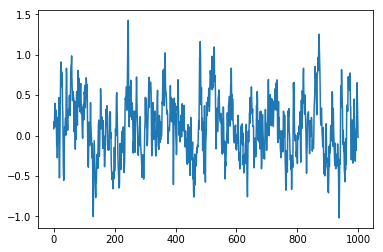

In [20]:
#@title
# UTILS
def soft_update(target, source, tau):
	"""
	Copies the parameters from source network (x) to target network (y) using the below update
	y = TAU*x + (1 - TAU)*y
	:param target: Target network (PyTorch)
	:param source: Source network (PyTorch)
	:return:
	"""
	for target_param, param in zip(target.parameters(), source.parameters()):
		target_param.data.copy_(
			target_param.data * (1.0 - tau) + param.data * tau
		)


def hard_update(target, source):
	"""
	Copies the parameters from source network to target network
	:param target: Target network (PyTorch)
	:param source: Source network (PyTorch)
	:return:
	"""
	for target_param, param in zip(target.parameters(), source.parameters()):
			target_param.data.copy_(param.data)


def save_training_checkpoint(state, is_best, episode_count):
	"""
	Saves the models, with all training parameters intact
	:param state:
	:param is_best:
	:param filename:
	:return:
	"""
	filename = str(episode_count) + 'checkpoint.path.rar'
	torch.save(state, filename)
	if is_best:
		shutil.copyfile(filename, 'model_best.pth.tar')


# Based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckActionNoise:

	def __init__(self, action_dim, mu = 0, theta = 0.15, sigma = 0.2):
		self.action_dim = action_dim
		self.mu = mu
		self.theta = theta
		self.sigma = sigma
		self.X = np.ones(self.action_dim) * self.mu

	def reset(self):
		self.X = np.ones(self.action_dim) * self.mu

	def sample(self):
		dx = self.theta * (self.mu - self.X)
		dx = dx + self.sigma * np.random.randn(len(self.X))
		self.X = self.X + dx
		return self.X


# use this to plot Ornstein Uhlenbeck random motion
if __name__ == '__main__':
	ou = OrnsteinUhlenbeckActionNoise(1)
	states = []
	for i in range(1000):
		states.append(ou.sample())
	import matplotlib.pyplot as plt

	plt.plot(states)
	plt.show()

## MAIN

In [0]:
#@title
# MAIN
##############################################
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from IPython.display import clear_output
##############################################
def ddpg(file_name="video"):
  env = BipedalWalkerHardcore() #Aquí se elige que entorno será
  env.reset()
  ################################
#   quiero_n_videos=10
  ###############################
  MAX_EPISODES = 500
  MAX_STEPS = 1000
  MAX_BUFFER = 1000000
  MAX_TOTAL_REWARD = 300
  S_DIM = env.observation_space.shape[0]
  A_DIM = env.action_space.shape[0]
  A_MAX = env.action_space.high[0]

  print(" State Dimensions :- ", S_DIM)
  print(" Action Dimensions :- ", A_DIM)
  print(" Action Max :- ", A_MAX)

  
  
  #ram = buffer.MemoryBuffer(MAX_BUFFER)
  ram = MemoryBuffer(MAX_BUFFER)
  #trainer = train.Trainer(S_DIM, A_DIM, A_MAX, ram)
  trainer = Trainer(S_DIM, A_DIM, A_MAX, ram)
  ###################################################
  ###################################################
  ###################################################
  ###################################################
  ###################################################
  
  trainer.load_models(400)
  ###################################################
  ###################################################
  ###################################################
  ###################################################
  ###################################################
  
  prev_screen = env.render(mode='rgb_array')
  plt.imshow(prev_screen)
  num_video=1
  total_reward=0
  ###################################################
  for _ep in range(MAX_EPISODES):

    observation = env.reset()
    # print ('EPISODE :- ', _ep)
    ###################################################
    video=[]
    total_reward=0
    #prev_screen = env.render(mode='rgb_array')
    #plt.imshow(prev_screen)
    ###################################################  
    if (_ep%10==0):
      clear_output(wait=True)
    for r in range(MAX_STEPS):
      #env.render()
      if (r%5==0 and r!=0 and _ep%100==0):
        screen = env.render(mode='rgb_array')
        video.append(screen)

      state = np.float32(observation)

      action = trainer.get_exploration_action(state)
      # if _ep%5 == 0:
      # 	# validate every 5th episode
      # 	action = trainer.get_exploitation_action(state)
      # else:
      # 	# get action based on observation, use exploration policy here
      # 	action = trainer.get_exploration_action(state)

      new_observation, reward, done, info = env.step(action)

      # # dont update if this is validation
      # if _ep%50 == 0 or _ep>450:
      # 	continue
      ###################################################
      total_reward+=reward
      if (r%100==0) and (r!=0):
        print("EPISODE :- "+str(_ep)+" STEP "+str(r)+' REWARD '
              +str(total_reward)+'/'+str(MAX_TOTAL_REWARD))
        # print(" STEP "+str(r)+' REWARD '+str(total_reward)+'/'+str(MAX_TOTAL_REWARD))
      
        #plt.imshow(screen)
        #ipythondisplay.clear_output(wait=True)
        #ipythondisplay.display(plt.gcf())
      
      ###################################################
      
      if done:
        new_state = None
      else:
        new_state = np.float32(new_observation)
        # push this exp in ram
        ram.add(state, action, reward, new_state)

      observation = new_observation

      # perform optimization
      trainer.optimize()
      if done: break

      # check memory consumption and clear memory
      gc.collect()
      # process = psutil.Process(os.getpid())
      # print(process.memory_info().rss)
    ############################################################
#     if _ep!=0 and _ep%int(MAX_EPISODES/quiero_n_videos)==0:
#       file_name_temp=file_name+str(num_video)
#       file_name_temp.replace(" ", "")
#       print("DDPG: Vamos a generar el video"+file_name_temp+".mp4")
#       generate_video(video,file_name_temp)
#       print("DDPG: Vamos a borrar el video"+file_name_temp+".mp4")
#       deleter(len(video))
#       try:
#           #files.download("/content/"+file_name_temp+".mp4")
#           print("DDPG: NO Descargando...")
#       except:
#           print("DDPG: No se pudo descargar correctamente, hágalo manual")
#           pass
    if _ep%100 == 0 or total_reward>50.0:
      #input("Escribe cualquier cosa")
      #trainer.save_models(_ep)
      trainer.save_models(_ep)
      print("DDPG: Episodio",_ep,"guardado")
    num_video+=1
    ############################################################
  print ('DDPG: Todos los episodios finalizados, ya se debería',
         'haber descargado todos los videos')
  env.close()

## ddpg_pt_to_mp4

In [0]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms

def ddpg_pt_to_mp4(file_episode=100,mini=0,just_one=0,sufijo=0):
  env = BipedalWalkerHardcore()
  
  MAX_EPISODES = 1 # SOLO QUEREMOS UNA ITERACION
  MAX_STEPS = 1000
  MAX_BUFFER = 1000000
  MAX_TOTAL_REWARD = 300
  S_DIM = env.observation_space.shape[0]
  A_DIM = env.action_space.shape[0]
  A_MAX = env.action_space.high[0]

  print(" State Dimensions :- ", S_DIM)
  print(" Action Dimensions :- ", A_DIM)
  print(" Action Max :- ", A_MAX)

  ram = MemoryBuffer(MAX_BUFFER)
  trainer = Trainer(S_DIM, A_DIM, A_MAX, ram)
  trainer.load_models(file_episode)# _ep+'_actor o _critic'+'.pt'
  
  observation = env.reset()
  video=[]
  total_reward=0
  for r in range(MAX_STEPS):
    if (r%5==0 and r!=0 ):
      screen = env.render(mode='rgb_array')
      video.append(screen)
    state = np.float32(observation)
    action = trainer.get_exploration_action(state)
    new_observation, reward, done, info = env.step(action)
    
    if done:
      new_state = None
    else:
      new_state = np.float32(new_observation)
      ram.add(state, action, reward, new_state)
    observation = new_observation
    trainer.optimize()
    if (r%10==0): print(" STEP "+str(r)+' REWARD '+str(total_reward)+'/'+str(MAX_TOTAL_REWARD))
    total_reward+=reward
    if done: break
    gc.collect() 
  if mini<=total_reward or just_one==1:
    print("DDPG: Vamos a generar el video"+str(file_episode)+"_"+str(sufijo)+".mp4")
    file_episode=file_episode+"_"+str(sufijo)
    generate_video(video,str(file_episode))
    print("DDPG: Vamos a borrar el video"+str(file_episode)+"_"+str(sufijo)+".mp4")
    deleter(len(video))
    print ('Script finalizado c:')
    
  env.close()
  return total_reward

# Generar video en Buffer para descargar

## Habilitar algoritmo

In [23]:
# Generar video
from google.colab import files
  # Colab desconecta en 300 y 600 solo 
  # poner RECONECTAR y dejar que el algoritmo termine
iniciar=0
if iniciar==1:
  file_name=input("Ingrese nombre del archivo que desea generar:")
  #if file_name==0: file_name="vid"
  print("El archivo se llamará "+file_name+".mp4")
  print("Ejecutando el algoritmo ...")
  ######################################################

  # algoritmos disponibles
  # -heuristic(file_name)
  # -ddpg(file_name)
  ######################################################

else:
  print("Cambia la variable iniciar a 1 no olvides elegir el método")

Cambia la variable iniciar a 1 no olvides elegir el método


In [0]:
# ddpg(file_name)

## Generar video a partir de archivo _.pt to mp4
 No olvides subir el archivo pt a  /content/

In [0]:
# Este algotimo genera el video para el modelo de actor y critic
# number_actor.pt
# number_critic.pt
# min es el minimo score que debe sacar para generar un video
def max_reward_video():
    max_reward=0
    total_reward=0
    itera=0
    number=input("Ingrese número de critic y actor. Ejem: 2600   ")
    while total_reward<90 and itera<15:
      sufijo=itera
      total_reward=ddpg_pt_to_mp4(number,0,1,sufijo)
      if total_reward>total_reward:
        max_reward=total_reward
      print("MAX reward in",str(itera),"is",str(max_reward))
      itera+=1
      print(itera)

# max_reward_video()

# ddpg_pt_to_mp4